##### Importing Libraries

In [1]:
import  pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import numpy as np
from datetime import datetime

#### Data Preparation & RFM Calculation

In [2]:
df = pd.read_excel(r'C:\Users\PC USER\Documents\GitHub\Daily-exercise\day_1_sales_analysis\Online%20Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
# Data Cleaning and creating new dataframe

customer_df = df.copy()
customer_df = customer_df.dropna(subset=['CustomerID'])
customer_df = customer_df[customer_df['Quantity'] > 0]
customer_df['Total_amount'] = customer_df['Quantity'] * customer_df['UnitPrice']
customer_df.head(5)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [4]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397924 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   InvoiceNo     397924 non-null  object        
 1   StockCode     397924 non-null  object        
 2   Description   397924 non-null  object        
 3   Quantity      397924 non-null  int64         
 4   InvoiceDate   397924 non-null  datetime64[ns]
 5   UnitPrice     397924 non-null  float64       
 6   CustomerID    397924 non-null  float64       
 7   Country       397924 non-null  object        
 8   Total_amount  397924 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 30.4+ MB


In [32]:
# Reference date (most recent date + 1 day)

reference_date = customer_df['InvoiceDate'].max() + pd.Timedelta(days=1)
reference_date

Timestamp('2011-12-10 12:50:00')

In [36]:
# Calculating RFM metrics for each customer

rfm_df = customer_df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days, # Recency
    'InvoiceNo': 'nunique', # Frequency
    'Total_amount': 'sum'    # Monetary
}).reset_index()

rfm_df.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
rfm_df.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


####  RFM Scoring & Segmentation

In [7]:
# Create RFM score (1-4, 4 being the best)

rfm_df['R_score'] = pd.qcut(rfm_df['Recency'], 4, labels=[4,3,2,1])
rfm_df['F_score'] = pd.qcut(rfm_df['Frequency'].rank(method='first'), 4, labels=[1,2,3,4], duplicates='drop')
rfm_df['M_score'] = pd.qcut(rfm_df['Monetary'], 4, labels=[1,2,3,4])

In [8]:
# converting the scores to integer

rfm_df['R_score'] = rfm_df['R_score'].astype(int)
rfm_df['F_score'] = rfm_df['F_score'].astype(int)
rfm_df['M_score'] = rfm_df['M_score'].astype(int)

In [9]:
# adding the scores as total score

rfm_df['Total_score'] = rfm_df['R_score'] + rfm_df['F_score'] + rfm_df['M_score']
rfm_df.head()

,CustomerID,Recency,Frequency,Monetary,R_score,F_score,M_score,Total_score
0,12346.0,326,1,77183.60,1,1,4,6
1,12347.0,2,7,4310.00,4,4,4,12
2,12348.0,75,4,1797.24,2,3,4,9
3,12349.0,19,1,1757.55,3,1,4,8
4,12350.0,310,1,334.40,1,1,2,4


In [10]:
# Define customer segments based on RFM scores

def segment_customer(row):
    if row['R_score'] >= 3 and row['F_score'] >= 3 and row['M_score'] >= 3:
        return 'Champions'
    elif row['R_score'] <= 2 and row['F_score'] >= 3 and row['M_score'] >= 3:
        return 'Loyal Customers'
    elif row['M_score'] >=3 and row['R_score'] <=2:
        return 'At resk'
    elif row['R_score'] >=3 and row['F_score'] <=2 or row['M_score'] <=2:
        return 'New/Cusual Customers'   
    else:
        return 'others'
rfm_df['segment'] = rfm_df.apply(segment_customer, axis=1)

rfm_df.head()

,CustomerID,Recency,Frequency,Monetary,R_score,F_score,M_score,Total_score,segment
0,12346.0,326,1,77183.60,1,1,4,6,At resk
1,12347.0,2,7,4310.00,4,4,4,12,Champions
2,12348.0,75,4,1797.24,2,3,4,9,Loyal Customers
3,12349.0,19,1,1757.55,3,1,4,8,New/Cusual Customers
4,12350.0,310,1,334.40,1,1,2,4,New/Cusual Customers


In [11]:
# average customer lifetime value

avg_clv = rfm_df['Monetary'].mean()
print(f"average cusrtomer lifetime value: ${avg_clv:.2f}")

average cusrtomer lifetime value: $2053.79


In [ ]:
# Top 10 customers by total spending

top_10_customer = rfm_df.nlargest(10, 'Monetary')[['CustomerID', 'Monetary', 'segment']]
print("Top_10_customers by spending:")
top_10_customer

Top_10_customers by spending:


,CustomerID,Monetary,segment
1690,14646.0,280206.02,Champions
4202,18102.0,259657.30,Champions
3729,17450.0,194550.79,Champions
3009,16446.0,168472.50,New/Cusual Customers
1880,14911.0,143825.06,Champions
55,12415.0,124914.53,Champions
1334,14156.0,117379.63,Champions
3772,17511.0,91062.38,Champions
2703,16029.0,81024.84,Champions
0,12346.0,77183.60,At resk


In [23]:
# purchase frequency distribution

frequency_dist = rfm_df['Frequency'].value_counts().sort_index()
print("\n Purchase Frequency Distribution:")
frequency_dist.reset_index().head()


 Purchase Frequency Distribution:


,Frequency,count
0,1,1494
1,2,835
2,3,508
3,4,387
4,5,243


In [ ]:
# segment_analysis

segment_analysis = rfm_df.groupby('segment').agg({
    'CustomerID': 'count',
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean' 
})

print("\n Segment Analysis:")
segment_analysis


 Segment Analysis:


,CustomerID,Recency,Frequency,Monetary
segment,,,,
At resk,264,148.522727,1.553030,1565.906292
Champions,1319,17.094769,9.378317,4932.935550
Loyal Customers,448,106.069196,4.687500,2136.950647
New/Cusual Customers,2308,126.585789,1.584055,448.055789


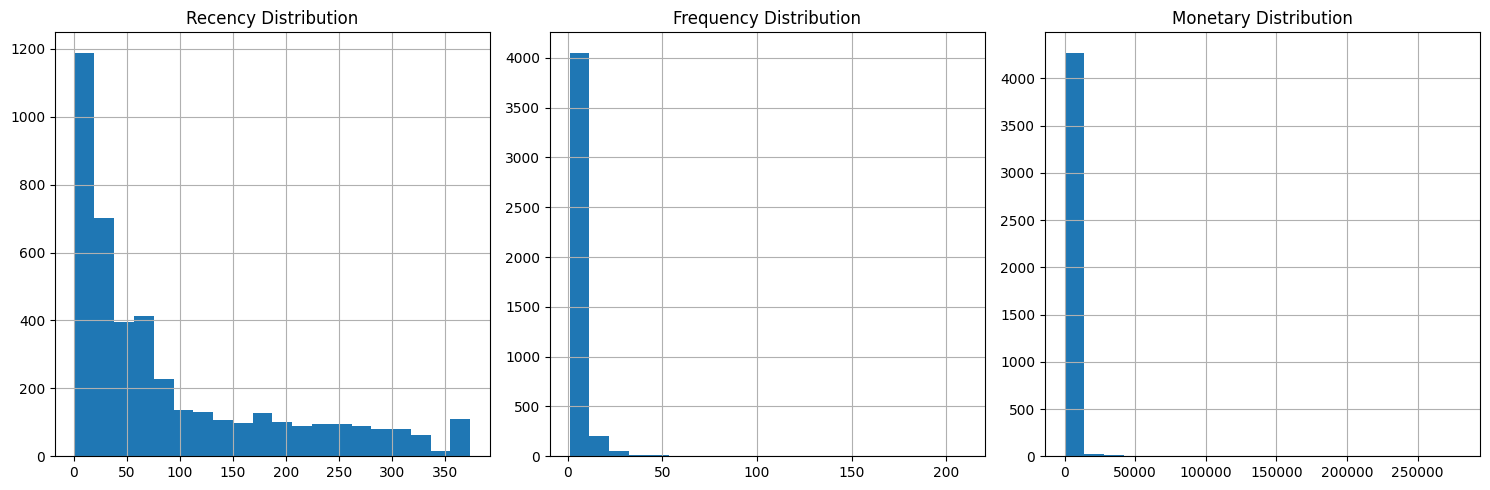

In [45]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
rfm_df['Recency'].hist(ax=axes[0], bins=20)
axes[0].set_title('Recency Distribution')
rfm_df['Frequency'].hist(ax=axes[1], bins=20)
axes[1].set_title('Frequency Distribution')
rfm_df['Monetary'].hist(ax=axes[2], bins=20)
axes[2].set_title('Monetary Distribution')
plt.tight_layout()
plt.show()

In [50]:
rfm_csv = rfm_df.to_csv('rfm_customer_segmentation.csv', index=False)